#### We've tried native forcating and SARIMA so far. In this section, we will use traditional ML models. Our main goal is to forecast tomorrow's ridership based on the previous 8 weeks data. The inputs of our model will a sequence of 56 days, and output will be a single value: the forecast for time step t+1.

In [1]:
import tensorflow as tf

my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [2]:
# another method
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [3]:
# to keep same batch size and convert the dataset into tensor

dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))

for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [4]:
def to_windows(dataset, length):
    dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [7]:
dataset = to_windows(tf.data.Dataset.range(6), 4) # 3 inputs + 1 target
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

#### Let's start training now, but before we need to split the data into train, validation and test. Now, we will focus on the rail ridership data, we will scale the data by a factor of 1 million to ensure the values are near the 0-1 range.

In [8]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [11]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [13]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

#### Forecating using a linear model

In [16]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = opt,
    metrics=["mae"]
)

history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=early_stopping_cb)

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.5305 - mae: 0.9041 - val_loss: 0.0437 - val_mae: 0.2327
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0287 - mae: 0.1815 - val_loss: 0.0106 - val_mae: 0.1097
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0108 - mae: 0.1104 - val_loss: 0.0073 - val_mae: 0.0913
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0080 - mae: 0.0918 - val_loss: 0.0064 - val_mae: 0.0861
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0076 - mae: 0.0885 - val_loss: 0.0059 - val_mae: 0.0816
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0063 - mae: 0.0795 - val_loss: 0.0052 - val_mae: 0.0750
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0785 - val_loss: 0.0063 - val_mae: 0.0872
Epoch 8/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0067 - 

33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0464 - val_loss: 0.0025 - val_mae: 0.0421
Epoch 64/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0471 - val_loss: 0.0024 - val_mae: 0.0410
Epoch 65/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0449 - val_loss: 0.0024 - val_mae: 0.0410
Epoch 66/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0450 - val_loss: 0.0024 - val_mae: 0.0406
Epoch 67/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0450 - val_loss: 0.0027 - val_mae: 0.0455
Epoch 68/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0449 - val_loss: 0.0026 - val_mae: 0.0479
Epoch 69/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0468 - val_loss: 0.0025 - val_mae: 0.0460
Epoch 70/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0

Epoch 125/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0027 - mae: 0.0459 - val_loss: 0.0024 - val_mae: 0.0428
Epoch 126/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0429 - val_loss: 0.0023 - val_mae: 0.0386
Epoch 127/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0424 - val_loss: 0.0023 - val_mae: 0.0387
Epoch 128/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0425 - val_loss: 0.0023 - val_mae: 0.0386
Epoch 129/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0032 - mae: 0.0534 - val_loss: 0.0023 - val_mae: 0.0386
Epoch 130/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0456 - val_loss: 0.0023 - val_mae: 0.0405
Epoch 131/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0437 - val_loss: 0.0024 - val_mae: 0.0425
Epoch 132/500
33/33 [==============================] - 0s 5ms/step - 

33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0440 - val_loss: 0.0023 - val_mae: 0.0383


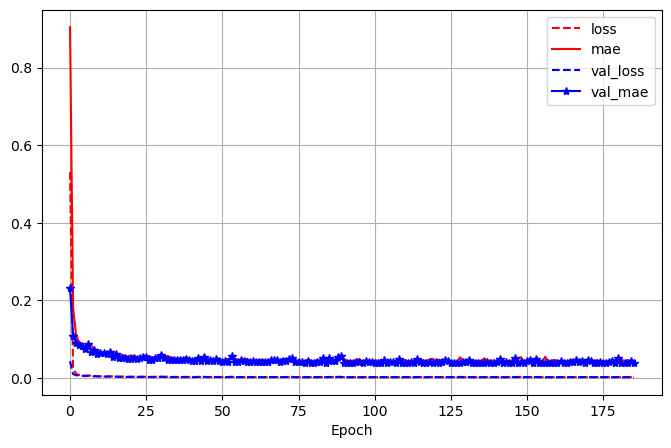

In [17]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(
    figsize = (8,5), grid=True, xlabel="Epoch",
    style=["r--", "r-", "b--", "b-*"]
)
plt.show()

This model worked better than the native forcasting but worse than the SARIMA model, let's try RNN.